In [1]:
import pandas as pd
import os
import csv
import re
import sys
import numpy as np
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

logging.getLogger('numba').setLevel(logging.WARNING)
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.colorbar').disabled = True
logging.getLogger('matplotlib.pyplot').disabled = True

#plt.style.use('dark_background')

In [2]:
# Function to extract the numeric part of the filename (after the last underscore and before the file extension)
def extract_numeric_part(path):
    # This regex extracts the number after the last underscore and before the file extension (.flac)
    match = re.search(r'_(\d+)\.flac$', path)
    if match:
        return match.group(1)  # Return only the numeric part
    return None  # Return None if the pattern doesn't match


def pred_and_labels_clean(file1_csv, file2_csv):
    '''
    file1: probabilities list .csv
    file2: eval dataset .csv
    '''
    
    prediction_list = []
    label_list = []
    pred_class1_list = []
    
    # Step 1: Read file2 into a dictionary for quick look-up based on the numeric part of the file path
    file2_dict = {}
    with open(file2_csv, mode='r') as file2:
        reader = csv.DictReader(file2)
        for row in reader:
            numeric_file2 = extract_numeric_part(row['path'])
            if numeric_file2:
                file2_dict[numeric_file2] = row['label']

    # Step 2: Traverse file1 and check against file2 dictionary, using tqdm for progress tracking
    with open(file1_csv, mode='r') as file1:
        reader = csv.DictReader(file1)
        total_rows = sum(1 for _ in open(file1_csv)) - 1  # Calculate total rows for the progress bar (excluding header)
    
        file1.seek(0)  # Reset the reader position back to the start of the file after counting
        for row in reader:
            # Extract the numeric part from file1's path
            file1_path = row['Filename']
            numeric_file1 = extract_numeric_part(file1_path)
        
            # Step 3: Check if the numeric part exists in the file2 dictionary
            if numeric_file1 and numeric_file1 in file2_dict:
                pred_class_0 = float(row['Pred.class 0'])
                pred_class_1 = float(row['Pred.class 1'])
            
                # Step 4: Append prediction based on comparison
                prediction_list.append(0 if pred_class_0 > pred_class_1 else 1)
            
                # Step 5: Append the corresponding label from file2
                label_list.append(int(file2_dict[numeric_file1]))
                
                # Step 6:  Append Pred.class 1 value to the new list
                pred_class1_list.append(pred_class_1)

    
    return prediction_list, label_list, pred_class1_list




def pred_and_labels_attack(file1_csv, file2_csv):
    
    def extract_numeric_part(path):
        # This regex captures the numeric part following 'LA_E_' and stops at the next underscore or period
        match = re.search(r'LA_E_(\d+)', path)
        if match:
            return match.group(1)  # Return only the numeric part
        return None  # Return None if the pattern doesn't match
    
    prediction_list = []
    label_list = []
    pred_class1_list = []
    
    # Step 1: Read file2 into a dictionary for quick look-up based on the numeric part of the file path
    file2_dict = {}
    with open(file2_csv, mode='r') as file2:
        reader = csv.DictReader(file2)
        for row in reader:
            numeric_file2 = extract_numeric_part(row['path'])
            if numeric_file2:
                file2_dict[numeric_file2] = row['label']

    # Step 2: Traverse file1 and check against file2 dictionary, using tqdm for progress tracking
    with open(file1_csv, mode='r') as file1:
        reader = csv.DictReader(file1)
        total_rows = sum(1 for _ in open(file1_csv)) - 1  # Calculate total rows for the progress bar (excluding header)
    
        file1.seek(0)  # Reset the reader position back to the start of the file after counting
        for row in reader:
            # Extract the numeric part from file1's path
            file1_path = row['Filename']
            numeric_file1 = extract_numeric_part(file1_path)
        
            # Step 3: Check if the numeric part exists in the file2 dictionary
            if numeric_file1 and numeric_file1 in file2_dict:
                pred_class_0 = float(row['Pred.class 0'])
                pred_class_1 = float(row['Pred.class 1'])
            
                # Step 4: Append prediction based on comparison
                prediction_list.append(0 if pred_class_0 > pred_class_1 else 1)
            
                # Step 5: Append the corresponding label from file2
                label_list.append(int(file2_dict[numeric_file1]))
                
                # Step 6:  Append Pred.class 1 value to the new list
                pred_class1_list.append(pred_class_1)

    
    return prediction_list, label_list, pred_class1_list

In [3]:
def ROC(attack, attack_model, epsilon, eval_model, model_version, dataset, type_of_spec, feature, q_1=None, q_2=None):
   
    epsilon_str = str(epsilon).replace('.', 'dot')
    
    script_dir = os.getcwd()
    probs_csv_c = f'probs_{eval_model}_{model_version}_clean_{dataset}_{type_of_spec}_{feature}.csv'
    if attack != 'Ensemble' and attack != 'Ensemble1D':
        probs_csv_p = f'probs_{eval_model}_{model_version}_{attack}_{attack_model}_{dataset}_{epsilon_str}_{type_of_spec}_{feature}.csv'
    elif attack == 'Ensemble':
        probs_csv_p = f'probs_{eval_model}_{model_version}_Ensemble_{dataset}_{q_1}_{q_2}_{epsilon_str}_{type_of_spec}_{feature}.csv'
    elif attack == 'Ensemble1D':
        probs_csv_p = f'probs_{eval_model}_{model_version}_{attack}_{dataset}_{q_1}_{q_2}_{epsilon_str}_{type_of_spec}_{feature}.csv'
        
    
    if dataset == '3s':
        eval_csv = os.path.join(os.path.dirname(script_dir), 'data', 'df_eval_19_3s.csv' )
    else:
        eval_csv = os.path.join(os.path.dirname(script_dir), 'data', 'df_eval_19.csv' )
    
    # get GT labels
    pred_list_c, labels_list_c, pred_1_c = pred_and_labels_clean(file1_csv=probs_csv_c, file2_csv=eval_csv)
    labels_c = np.array(labels_list_c)
    pred_1_c = np.array(pred_1_c)
    
    pred_list_p, labels_list_p, pred_1_p = pred_and_labels_attack(file1_csv=probs_csv_p, file2_csv=eval_csv)
    labels_p = np.array(labels_list_p)
    pred_1_p = np.array(pred_1_p)
    
    if len(pred_list_c) != len(pred_list_p):
        sys.exit(f'length of clean is {len(pred_list_c)}, length of clean is {len(pred_list_p)}')
    
    # CLEAN - compute ROC and AUC
    fpr_c, tpr_c, _ = roc_curve(labels_c, pred_1_c)
    roc_auc_c = auc(fpr_c, tpr_c)
    
    # PERTURBED - compute ROC and AUC
    fpr_p, tpr_p, _ = roc_curve(labels_p, pred_1_p)
    roc_auc_p = auc(fpr_p, tpr_p)
    
    # plot
    plt.figure()
    plt.plot(fpr_c, tpr_c, color='darkorange', lw=1.5, label='Clean (AUC={:.2f})'.format(roc_auc_c))
    plt.plot(fpr_p, tpr_p, color='red', lw=1.5, label='Perturbed (AUC={:.2f})'.format(roc_auc_p))
    plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
    # Set axis limits and labels
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC - {attack} on {attack_model}, eps={epsilon}, eval model: {eval_model}')
    plt.legend(loc='lower right')
    plt.show()
    
    return fpr_c, tpr_c, roc_auc_c, fpr_p, tpr_p, roc_auc_p

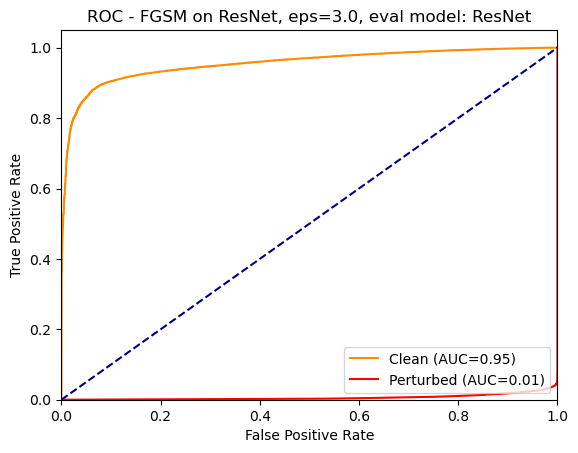

In [19]:
fpr_c_Res, tpr_c_Res, roc_auc_c_Res, fpr_ResFGSMRes, tpr_ResFGSMRes, roc_auc_ResFGSMRes =(
    ROC(attack='FGSM', attack_model='ResNet', epsilon=3.0, eval_model='ResNet', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio'))

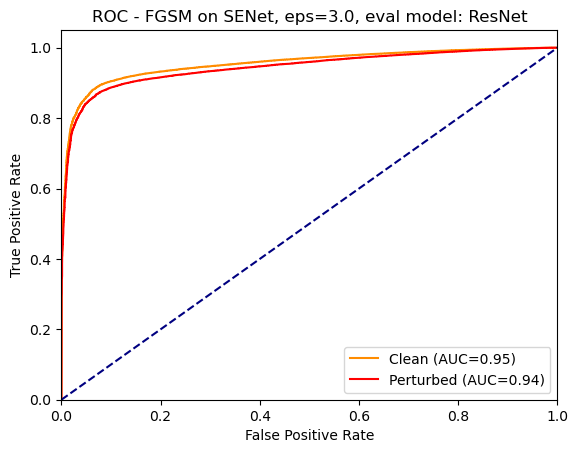

In [25]:
_, _, _, fpr_ResFGSMSen, tpr_ResFGSMSen, roc_auc_ResFGSMSen = (
    ROC(attack='FGSM', attack_model='SENet', epsilon=3.0, eval_model='ResNet', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio'))

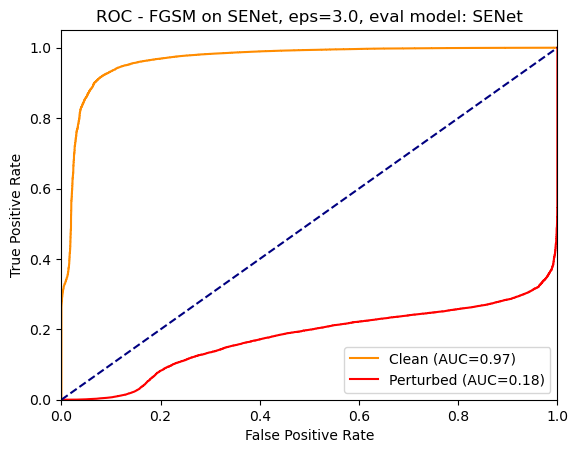

In [21]:
fpr_c_Sen, tpr_c_Sen, roc_auc_c_Sen, fpr_SenFGSMSen, tpr_SenFGSMSen, roc_auc_SenFGSMSen =(
    ROC(attack='FGSM', attack_model='SENet', epsilon=3.0, eval_model='SENet', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio'))

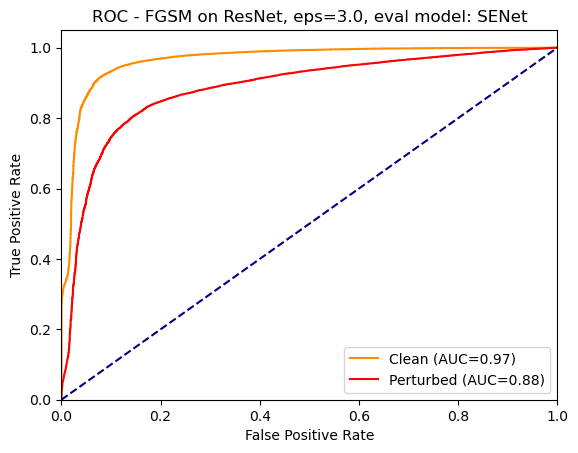

In [22]:
_, _, _, fpr_SenFGSMRes, tpr_SenFGSMRes, roc_auc_SenFGSMRes = (
    ROC(attack='FGSM', attack_model='ResNet', epsilon=3.0, eval_model='SENet', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio'))

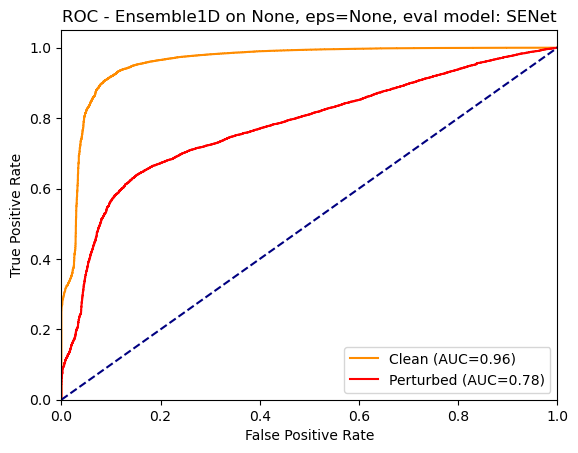

In [34]:
_, _, _, fpr_SenEns1D, tpr_SenEns1D, roc_auc_SenEns1D = (
    ROC(attack='Ensemble1D', attack_model=None, epsilon=None, eval_model='SENet', model_version='v0', dataset='3s', type_of_spec='pow', feature='audio', q_1=10, q_2=10))

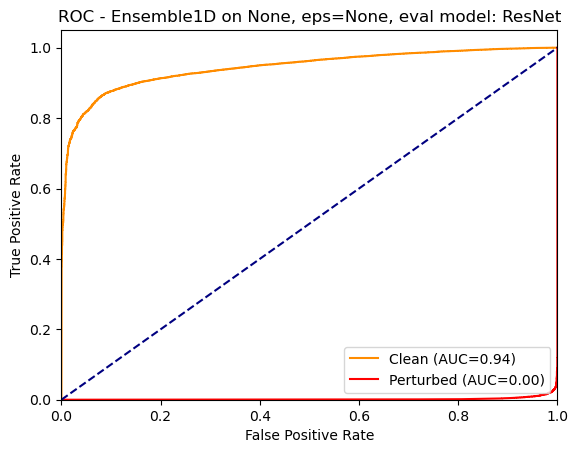

In [31]:
_, _, _, fpr_ResEns1D, tpr_ResEns1D, roc_auc_ResEns1D = (
    ROC(attack='Ensemble1D', attack_model=None, epsilon=None, eval_model='ResNet', model_version='v0', dataset='3s', type_of_spec='pow', feature='audio', q_1=10, q_2=10))

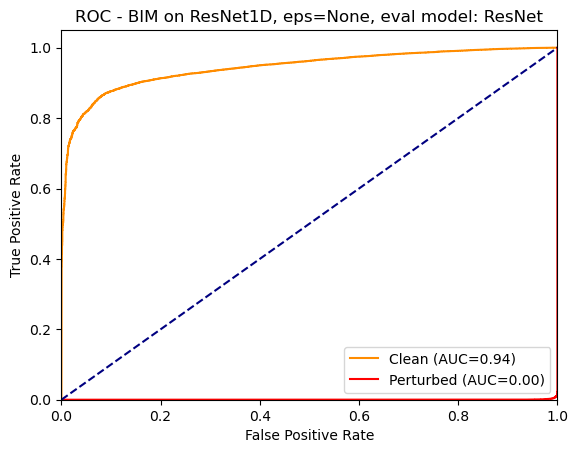

In [48]:
_, _, _, fpr_ResBIM1D, tpr_ResBIM1D, roc_auc_ResBIM1D = (
    ROC(attack='BIM', attack_model='ResNet1D', epsilon=None, eval_model='ResNet', model_version='v0', dataset='3s', type_of_spec='pow', feature='audio', q_1=10, q_2=10))

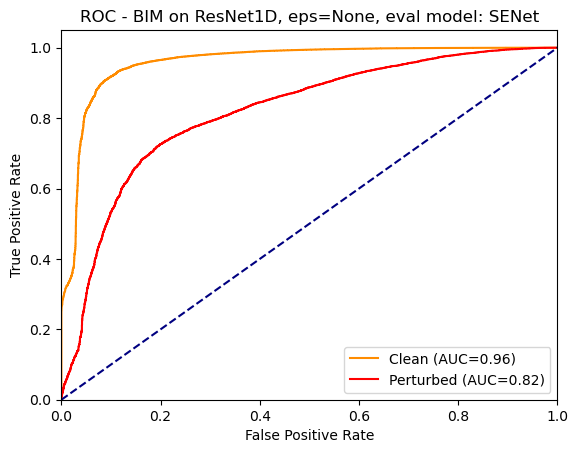

In [49]:
_, _, _, fpr_SenBIM1D, tpr_SenBIM1D, roc_auc_SenBIM1D  =(
    ROC(attack='BIM', attack_model='ResNet1D', epsilon=None, eval_model='SENet', model_version='v0', dataset='3s', type_of_spec='pow', feature='audio', q_1=10, q_2=10))

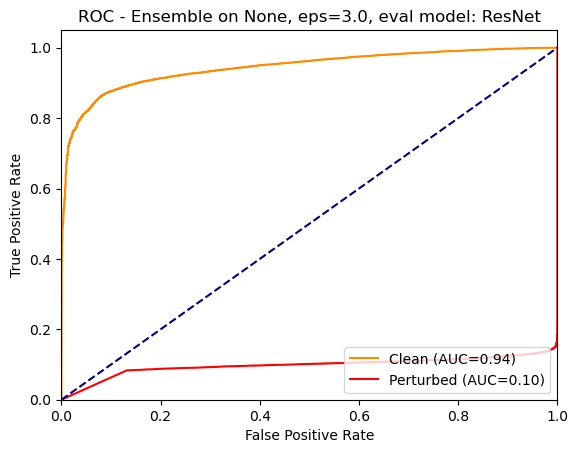

In [57]:
_, _, _, fpr_ResEns2D, tpr_ResEns2D, roc_auc_ResEns2D = ROC(attack='Ensemble', attack_model=None, epsilon=3.0, eval_model='ResNet', model_version='v0', dataset='3s', type_of_spec='pow', feature='audio', q_1=10, q_2=10)

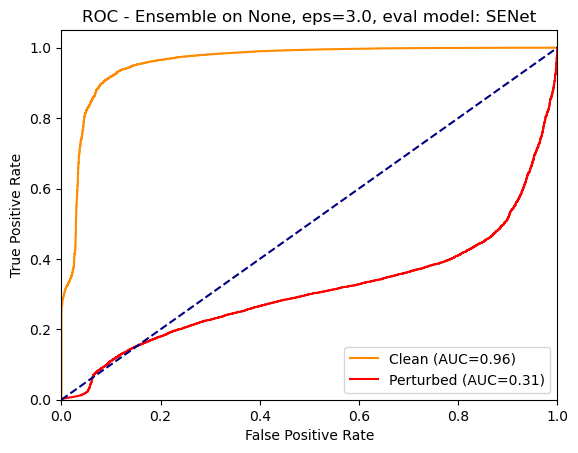

In [58]:
_, _, _, fpr_SenEns2D, tpr_SenEns2D, roc_auc_SenEns2D = ROC(attack='Ensemble', attack_model=None, epsilon=3.0, eval_model='SENet', model_version='v0', dataset='3s', type_of_spec='pow', feature='audio', q_1=10, q_2=10)

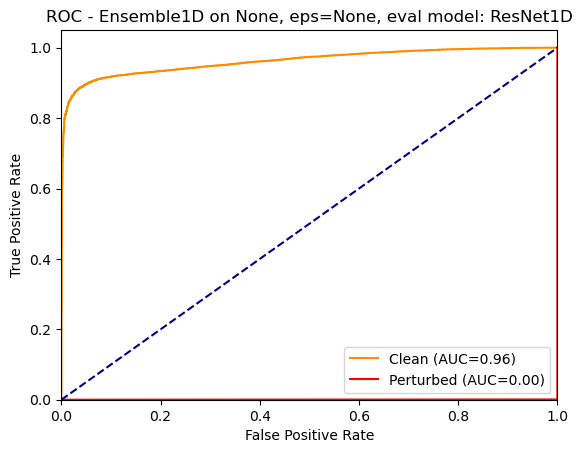

In [69]:
_,_,_,_,_,_ = ROC(attack='Ensemble1D', attack_model=None, epsilon=None, eval_model='ResNet1D', model_version='v0', dataset='3s', type_of_spec='pow', feature='audio', q_1=10, q_2=10)

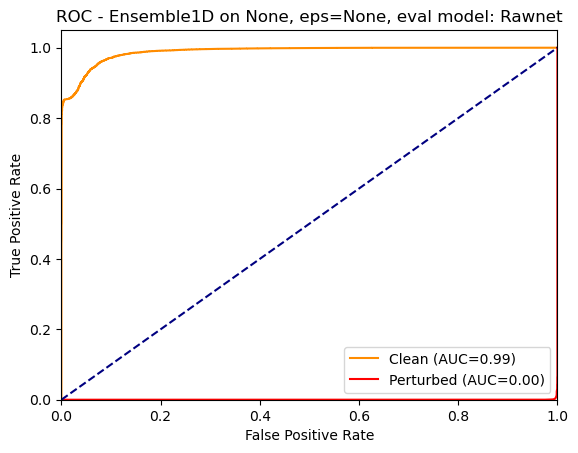

In [7]:
fpr_c_Raw, tpr_c_Raw, roc_auc_c_Raw, fpr_RawEns1D, tpr_RawEns1D, roc_auc_RawEns1D = ROC(attack='Ensemble1D', attack_model=None, epsilon=None, eval_model='Rawnet', model_version='v0', dataset='3s', type_of_spec='pow', feature='audio', q_1=10, q_2=10)

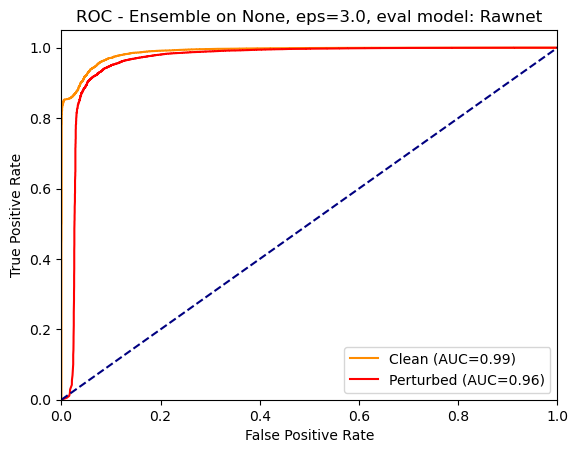

In [10]:
_,_,_, fpr_RawEns2D, tpr_RawEns2D, roc_auc_RawEns2D = ROC(attack='Ensemble', attack_model=None, epsilon=3.0, eval_model='Rawnet', model_version='v0', dataset='3s', type_of_spec='pow', feature='audio', q_1=10, q_2=10)

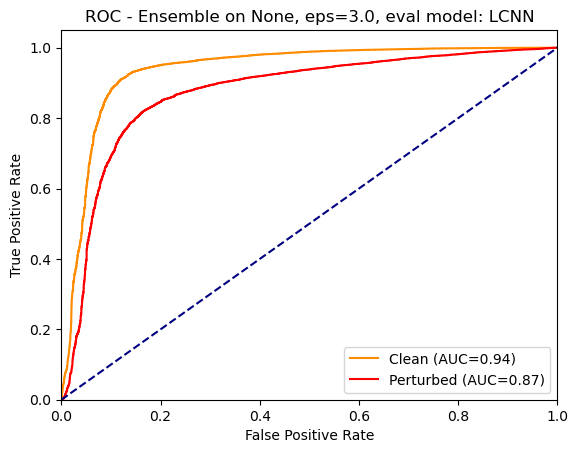

In [13]:
fpr_c_LCNN, tpr_c_LCNN, roc_auc_c_LCNN, fpr_LCNNEns2D, tpr_LCNNEns2D, roc_auc_LCNNEns2D = ROC(attack='Ensemble', attack_model=None, epsilon=3.0, eval_model='LCNN', model_version='v0', dataset='3s', type_of_spec='pow', feature='audio', q_1=10, q_2=10)

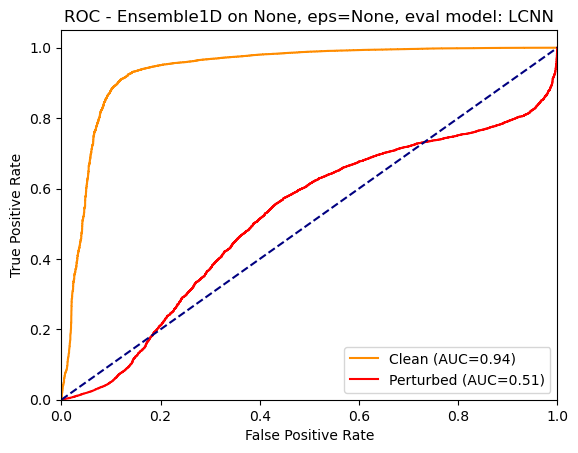

In [14]:
_,_,_, fpr_LCNNEns1D, tpr_LCNNEns1D, roc_auc_LCNNEns1D = ROC(attack='Ensemble1D', attack_model=None, epsilon=None, eval_model='LCNN', model_version='v0', dataset='3s', type_of_spec='pow', feature='audio', q_1=10, q_2=10)

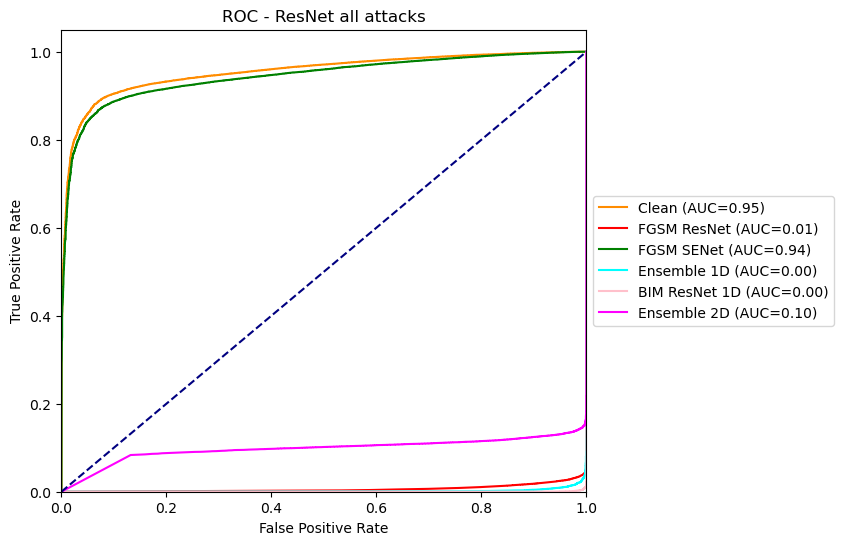

In [60]:
# plot ResNet
plt.figure()
plt.gcf().set_size_inches(6, 6)
plt.plot(fpr_c_Res, tpr_c_Res, color='darkorange', lw=1.5, label='Clean (AUC={:.2f})'.format(roc_auc_c_Res))
plt.plot(fpr_ResFGSMRes, tpr_ResFGSMRes, color='red', lw=1.5, label='FGSM ResNet (AUC={:.2f})'.format(roc_auc_ResFGSMRes))
plt.plot(fpr_ResFGSMSen, tpr_ResFGSMSen, color='green', lw=1.5, label='FGSM SENet (AUC={:.2f})'.format(roc_auc_ResFGSMSen))
plt.plot(fpr_ResEns1D, tpr_ResEns1D, color='cyan', lw=1.5, label='Ensemble 1D (AUC={:.2f})'.format(roc_auc_ResEns1D))
plt.plot(fpr_ResBIM1D, tpr_ResBIM1D, color='pink', lw=1.5, label='BIM ResNet 1D (AUC={:.2f})'.format(roc_auc_ResBIM1D))
plt.plot(fpr_ResEns2D, tpr_ResEns2D, color='magenta', lw=1.5, label='Ensemble 2D (AUC={:.2f})'.format(roc_auc_ResEns2D))
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC - ResNet all attacks')
plt.subplots_adjust(right=1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

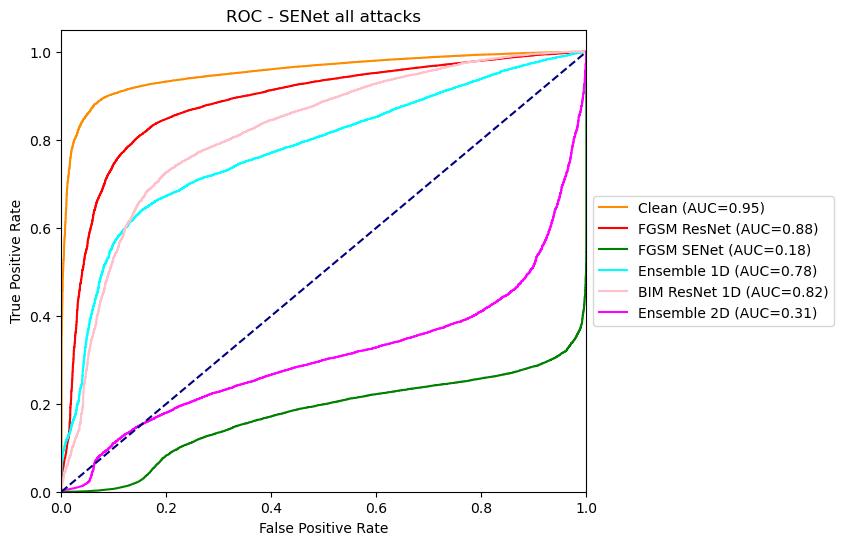

In [61]:
# plot SENet
plt.figure()
plt.gcf().set_size_inches(6, 6)
plt.plot(fpr_c_Res, tpr_c_Res, color='darkorange', lw=1.5, label='Clean (AUC={:.2f})'.format(roc_auc_c_Res))
plt.plot(fpr_SenFGSMRes, tpr_SenFGSMRes, color='red', lw=1.5, label='FGSM ResNet (AUC={:.2f})'.format(roc_auc_SenFGSMRes))
plt.plot(fpr_SenFGSMSen, tpr_SenFGSMSen, color='green', lw=1.5, label='FGSM SENet (AUC={:.2f})'.format(roc_auc_SenFGSMSen))
plt.plot(fpr_SenEns1D, tpr_SenEns1D, color='cyan', lw=1.5, label='Ensemble 1D (AUC={:.2f})'.format(roc_auc_SenEns1D))
plt.plot(fpr_SenBIM1D, tpr_SenBIM1D, color='pink', lw=1.5, label='BIM ResNet 1D (AUC={:.2f})'.format(roc_auc_SenBIM1D))
plt.plot(fpr_SenEns2D, tpr_SenEns2D, color='magenta', lw=1.5, label='Ensemble 2D (AUC={:.2f})'.format(roc_auc_SenEns2D))
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
# Set axis limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC - SENet all attacks')
plt.subplots_adjust(right=1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()